In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

train_file_path = 'ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet'
test_file_path  = 'ML-Project/test-00000-of-00001-44110b9df98c5585.parquet'

print("Loading parquet files...")
train_df = pd.read_parquet(train_file_path)
test_df = pd.read_parquet(test_file_path)

# ---------------------------------------------
# FUNCTION TO DECODE JPEG BYTES
# ---------------------------------------------
IMG_SIZE = (208, 176)

def decode_image(img_dict):
    # extract raw bytes
    img_bytes = img_dict["bytes"]

    # convert bytes → tensor
    img = tf.io.decode_jpeg(img_bytes, channels=3)

    # resize
    img = tf.image.resize(img, IMG_SIZE)

    # convert to numpy
    return img.numpy()

# ---------------------------------------------
# Decode all train/test images
# ---------------------------------------------
train_images = np.array([decode_image(img) for img in train_df["image"]])
test_images  = np.array([decode_image(img) for img in test_df["image"]])

train_labels = train_df["label"].to_numpy()
test_labels  = test_df["label"].to_numpy()

# ---------------------------------------------
# Preprocess for VGG16
# ---------------------------------------------
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)

# ---------------------------------------------
# VGG16 feature extraction
# ---------------------------------------------
print("Extracting VGG16 features...")

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    pooling="avg"
)

train_features = base_model.predict(train_images, verbose=1)
test_features = base_model.predict(test_images, verbose=1)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels,
    test_size=0.2,
    random_state=42
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_features)

# ---------------------------------------------
# SVM
# ---------------------------------------------
print("Training SVM...")
svm_clf = SVC(kernel="linear")
svm_clf.fit(X_train, y_train)

val_pred = svm_clf.predict(X_val)
test_pred = svm_clf.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(test_labels, test_pred))


Loading parquet files...
Extracting VGG16 features...
160/160 ━━━━━━━━━━━━━━━━━━━━ 1206s 8s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 301s 8s/step
Training SVM...
Validation Accuracy: 0.681640625
Test Accuracy: 0.67578125


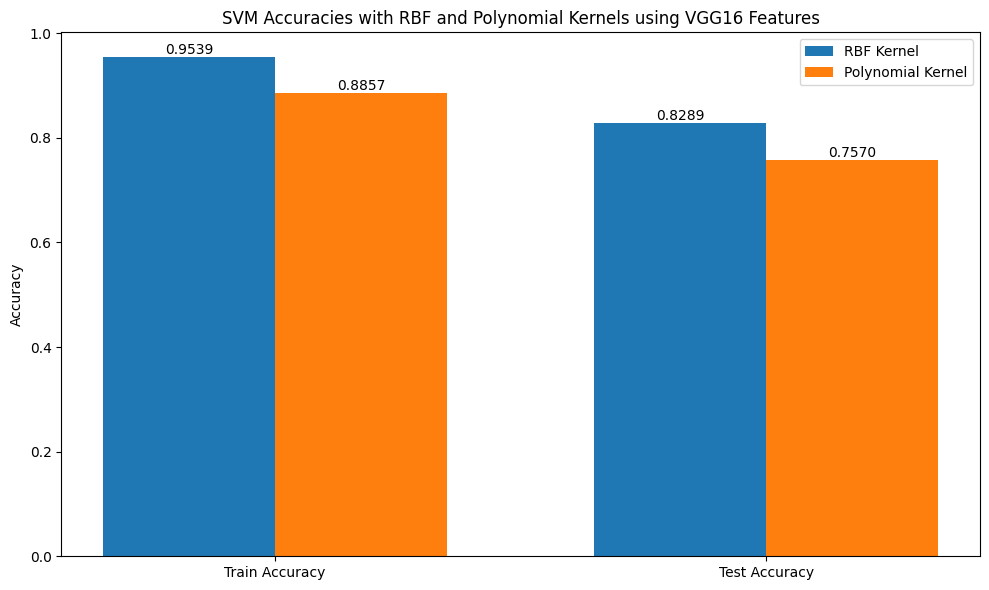

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

# Use scaled features
X_train_svm = scaler.fit_transform(train_features)
X_test_svm = scaler.transform(test_features)

y_train_svm = train_labels
y_test_svm = test_labels

# ---------------------------------------------
# RBF Kernel
# ---------------------------------------------
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train_svm, y_train_svm)

rbf_train_accuracy = svm_rbf.score(X_train_svm, y_train_svm)
rbf_test_accuracy = svm_rbf.score(X_test_svm, y_test_svm)

# ---------------------------------------------
# Polynomial Kernel
# ---------------------------------------------
svm_poly = SVC(kernel='poly', C=1.0, gamma='scale', degree=3)
svm_poly.fit(X_train_svm, y_train_svm)

poly_train_accuracy = svm_poly.score(X_train_svm, y_train_svm)
poly_test_accuracy = svm_poly.score(X_test_svm, y_test_svm)

# ---------------------------------------------
# Visualization
# ---------------------------------------------
labels = ['Train Accuracy', 'Test Accuracy']
rbf_accuracies = [rbf_train_accuracy, rbf_test_accuracy]
poly_accuracies = [poly_train_accuracy, poly_test_accuracy]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
rbf_bars = plt.bar(x - width/2, rbf_accuracies, width, label='RBF Kernel')
poly_bars = plt.bar(x + width/2, poly_accuracies, width, label='Polynomial Kernel')

# Add text labels above bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=10)

add_value_labels(rbf_bars)
add_value_labels(poly_bars)

plt.ylabel('Accuracy')
plt.title('SVM Accuracies with RBF and Polynomial Kernels using VGG16 Features')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

train_file_path = "ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet"

df = pd.read_parquet(train_file_path)

print("Columns:", df.columns.tolist())
print(df.head())
print("Dtypes:", df.dtypes)


Columns: ['image', 'label']
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
Dtypes: image    object
label     int64
dtype: object


__Pipeline: Parquet (JPEG bytes) -> VGG16 features -> SVM (RBF / Poly)__

Loading parquet files...
Train shape: (5120, 2) Test shape: (1280, 2)
Decoding train images...
Decoding test images...
Decoded shapes: (5120, 208, 176, 3) (1280, 208, 176, 3)
Label distribution (train): [ 724   49 2566 1781]
Label distribution (test) : [172  15 634 459]
Loading VGG16 and extracting features (this may take a while)...
160/160 ━━━━━━━━━━━━━━━━━━━━ 1193s 7s/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 297s 7s/step
Feature shapes: (5120, 512) (1280, 512)
Training SVM (RBF)...
RBF validation accuracy: 0.8105
RBF test accuracy:       0.7953
RBF classification report (test):
              precision    recall  f1-score   support

           0       0.92      0.54      0.68       172
           1       1.00      0.27      0.42        15
           2       0.79      0.91      0.85       634
           3       0.77      0.75      0.76       459

    accuracy                           0.80      1280
   macro avg       0.87      0.62      0.68      1280
weighted avg       0.80      0.80      0.

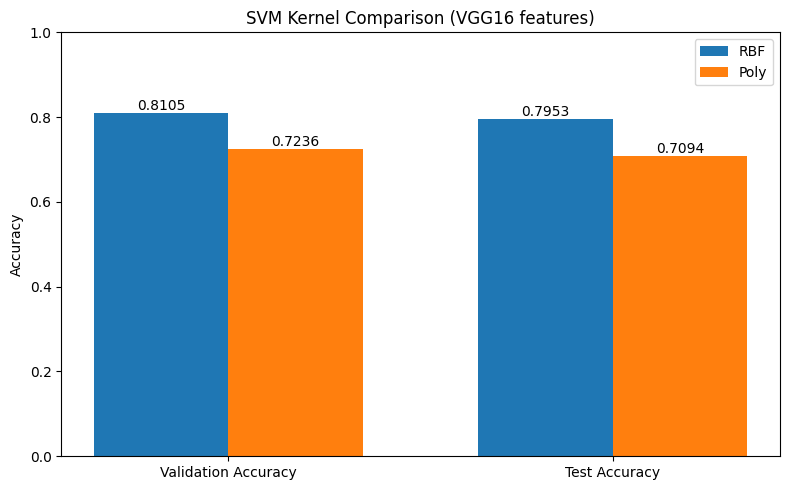

In [8]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


train_file_path = 'ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet'
test_file_path  = 'ML-Project/test-00000-of-00001-44110b9df98c5585.parquet'

# -----------------------------
# Read parquet files
# -----------------------------
print("Loading parquet files...")
train_df = pd.read_parquet(train_file_path)
test_df  = pd.read_parquet(test_file_path)
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

# Quick sanity check
if 'image' not in train_df.columns or 'label' not in train_df.columns:
    raise RuntimeError("Expected columns 'image' and 'label' in the Parquet files.")

# -----------------------------
# Decode JPEG bytes -> numpy image (H,W,3)
# -----------------------------
IMG_SIZE = (208, 176)  # height, width (matches your previous target_size)

def decode_and_resize(img_entry, img_size=IMG_SIZE):
    """
    img_entry expected to be a dict-like with key 'bytes' containing JPEG bytes.
    Returns a float32 numpy array shape (H, W, 3) ready for preprocess_input.
    """
    # Accept either dict with 'bytes' or raw bytes
    if isinstance(img_entry, dict):
        img_bytes = img_entry.get('bytes')
    else:
        img_bytes = img_entry

    if img_bytes is None:
        raise ValueError("Image entry contained no bytes.")

    # Ensure bytes type
    if not isinstance(img_bytes, (bytes, bytearray, memoryview)):
        raise ValueError("Image bytes are not raw bytes. Got type: {}".format(type(img_bytes)))

    # Decode JPEG to tensor (forces 3 channels)
    img_tensor = tf.io.decode_jpeg(img_bytes, channels=3)  # uint8 tensor [H,W,3]
    img_tensor = tf.image.resize(img_tensor, img_size)     # float32 tensor
    # Convert to numpy float32
    return img_tensor.numpy().astype(np.float32)

# Decode all images (this may use memory proportional to dataset size)
print("Decoding train images...")
train_images = np.array([decode_and_resize(e) for e in train_df["image"].to_list()])
print("Decoding test images...")
test_images  = np.array([decode_and_resize(e) for e in test_df["image"].to_list()])

train_labels = train_df["label"].to_numpy()
test_labels  = test_df["label"].to_numpy()

print("Decoded shapes:", train_images.shape, test_images.shape)
print("Label distribution (train):", np.bincount(train_labels))
print("Label distribution (test) :", np.bincount(test_labels))

# -----------------------------
# Preprocess for VGG16
# -----------------------------
# VGG16.preprocess_input expects RGB images in float format; using the function is correct
train_images_pp = preprocess_input(train_images.copy())
test_images_pp  = preprocess_input(test_images.copy())

# -----------------------------
# Feature extraction with VGG16
# -----------------------------
print("Loading VGG16 and extracting features (this may take a while)...")
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3), pooling="avg")

# Batch predict to avoid memory spikes
def extract_features_in_batches(model, images, batch_size=32):
    features = model.predict(images, batch_size=batch_size, verbose=1)
    return features

train_features = extract_features_in_batches(base_model, train_images_pp, batch_size=32)
test_features  = extract_features_in_batches(base_model, test_images_pp,  batch_size=32)

print("Feature shapes:", train_features.shape, test_features.shape)

# -----------------------------
# Train/validation split (from train_features)
# -----------------------------
X_train_full, X_val, y_train_full, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Train SVM on X_train_full and validate on X_val; final test on test_features/test_labels
# -----------------------------
# Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_features)

# -----------------------------
# Train SVM (RBF)
# -----------------------------
print("Training SVM (RBF)...")
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_scaled, y_train_full)

# Evaluate
rbf_val_pred = svm_rbf.predict(X_val_scaled)
rbf_test_pred = svm_rbf.predict(X_test_scaled)
rbf_val_acc = accuracy_score(y_val, rbf_val_pred)
rbf_test_acc = accuracy_score(test_labels, rbf_test_pred)
print(f"RBF validation accuracy: {rbf_val_acc:.4f}")
print(f"RBF test accuracy:       {rbf_test_acc:.4f}")
print("RBF classification report (test):")
print(classification_report(test_labels, rbf_test_pred))

# -----------------------------
# Train SVM (Polynomial)
# -----------------------------
print("Training SVM (Poly degree=3)...")
svm_poly = SVC(kernel='poly', degree=3, C=1.0, gamma='scale', random_state=42)
svm_poly.fit(X_train_scaled, y_train_full)

poly_val_pred = svm_poly.predict(X_val_scaled)
poly_test_pred = svm_poly.predict(X_test_scaled)
poly_val_acc = accuracy_score(y_val, poly_val_pred)
poly_test_acc = accuracy_score(test_labels, poly_test_pred)
print(f"Poly validation accuracy: {poly_val_acc:.4f}")
print(f"Poly test accuracy:       {poly_test_acc:.4f}")
print("Poly classification report (test):")
print(classification_report(test_labels, poly_test_pred))

# -----------------------------
# Plot comparison bar chart
# -----------------------------
labels = ['Validation Accuracy', 'Test Accuracy']
rbf_vals = [rbf_val_acc, rbf_test_acc]
poly_vals = [poly_val_acc, poly_test_acc]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
rbf_bars = plt.bar(x - width/2, rbf_vals, width, label='RBF')
poly_bars = plt.bar(x + width/2, poly_vals, width, label='Poly')

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h, f"{h:.4f}", ha='center', va='bottom')

add_labels(rbf_bars)
add_labels(poly_bars)

plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("SVM Kernel Comparison (VGG16 features)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# ----------------------------------------------------------------------------------
# LOAD PARQUET DATA 
# ----------------------------------------------------------------------------------
train_file_path = 'ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet'
test_file_path  = 'ML-Project/test-00000-of-00001-44110b9df98c5585.parquet'

train_df = pd.read_parquet(train_file_path)
test_df  = pd.read_parquet(test_file_path)

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

# ----------------------------------------------------------------------------------
# DECODE JPEG BYTES → GRAYSCALE → RESIZE → NORMALIZE
# ----------------------------------------------------------------------------------
IMG_SIZE = (208, 176)

def decode_image(entry):
    if isinstance(entry, dict):
        img_bytes = entry["bytes"]
    else:
        img_bytes = entry

    img = tf.io.decode_jpeg(img_bytes, channels=3)         # RGB
    img = tf.image.rgb_to_grayscale(img)                  # convert to 1-channel
    img = tf.image.resize(img, IMG_SIZE)                  # resize
    img = img / 255.0                                     # normalize
    return img.numpy().astype("float32")

print("Decoding training images...")
train_images = np.array([decode_image(e) for e in train_df["image"]])
train_labels = train_df["label"].values

print("Decoding test images...")
test_images = np.array([decode_image(e) for e in test_df["image"]])
test_labels = test_df["label"].values

# One-hot encoding for CNN
train_labels_cat = to_categorical(train_labels, num_classes=4)
test_labels_cat  = to_categorical(test_labels, num_classes=4)

print("Final train image shape:", train_images.shape)

# ----------------------------------------------------------------------------------
# CNN MODEL (your architecture)
# ----------------------------------------------------------------------------------
def create_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(208, 176, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

def create_feature_extractor(cnn):
    return Model(inputs=cnn.inputs, outputs=cnn.layers[-2].output)

# ----------------------------------------------------------------------------------
# 5-FOLD CROSS VALIDATION
# ----------------------------------------------------------------------------------
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies_rbf = []
accuracies_poly = []
losses = []

fold_no = 1
labels_for_kfold = train_labels

for train_idx, val_idx in kf.split(train_images, labels_for_kfold):

    print(f"\n==========================")
    print(f"Training Fold {fold_no}")
    print(f"==========================")

    X_train = train_images[train_idx]
    X_val   = train_images[val_idx]
    y_train = train_labels_cat[train_idx]
    y_val   = train_labels_cat[val_idx]

    # ------------------ Train CNN ------------------
    cnn = create_cnn()
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    # ------------------ Extract Features ------------------
    feature_extractor = create_feature_extractor(cnn)

    X_train_feat = feature_extractor.predict(X_train)
    X_val_feat   = feature_extractor.predict(X_val)

    y_train_lbl = np.argmax(y_train, axis=1)
    y_val_lbl   = np.argmax(y_val, axis=1)

    # ------------------ SVM RBF ------------------
    svm_rbf = SVC(kernel='rbf')
    svm_rbf.fit(X_train_feat, y_train_lbl)
    pred_rbf = svm_rbf.predict(X_val_feat)
    acc_rbf = accuracy_score(y_val_lbl, pred_rbf)

    # ------------------ SVM Polynomial ------------------
    svm_poly = SVC(kernel='poly')
    svm_poly.fit(X_train_feat, y_train_lbl)
    pred_poly = svm_poly.predict(X_val_feat)
    acc_poly = accuracy_score(y_val_lbl, pred_poly)

    # ------------------ Store Results ------------------
    fold_loss = cnn.evaluate(X_val, y_val, verbose=0)[0]
    losses.append(fold_loss)
    accuracies_rbf.append(acc_rbf)
    accuracies_poly.append(acc_poly)

    print(f"Fold {fold_no} - CNN Loss: {fold_loss:.4f}")
    print(f"Fold {fold_no} - SVM RBF Accuracy: {acc_rbf:.4f}")
    print(f"Fold {fold_no} - SVM Polynomial Accuracy: {acc_poly:.4f}")

    fold_no += 1

# ----------------------------------------------------------------------------------
# FINAL RESULTS
# ----------------------------------------------------------------------------------
print("\n\n========== FINAL RESULTS ==========")
print("Mean CNN Loss:", np.mean(losses))
print("Mean SVM RBF Accuracy:", np.mean(accuracies_rbf))
print("Mean SVM Polynomial Accuracy:", np.mean(accuracies_poly))


Train shape: (5120, 2) Test shape: (1280, 2)
Decoding training images...
Decoding test images...
Final train image shape: (5120, 208, 176, 1)

Training Fold 1


C:\Users\akank\anaconda3\envs\algo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.4941 - loss: 1.0376 - val_accuracy: 0.5117 - val_loss: 1.0118
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5557 - loss: 0.9043 - val_accuracy: 0.6074 - val_loss: 0.8416
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.6086 - loss: 0.8145 - val_accuracy: 0.6406 - val_loss: 0.7628
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6724 - loss: 0.7021 - val_accuracy: 0.7285 - val_loss: 0.6273
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7375 - loss: 0.5778 - val_accuracy: 0.7910 - val_loss: 0.5383
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7988 - loss: 0.4598 - val_accuracy: 0.8301 - val_loss: 0.4360
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8511 - loss: 0.3633 - val_accuracy: 0.8584 - val_loss: 0.3971
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8735 - loss: 0.2837 - val_accu

C:\Users\akank\anaconda3\envs\algo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4917 - loss: 1.0562 - val_accuracy: 0.5693 - val_loss: 0.9423
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5715 - loss: 0.9123 - val_accuracy: 0.5635 - val_loss: 0.8809
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6211 - loss: 0.8153 - val_accuracy: 0.6631 - val_loss: 0.7407
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6956 - loss: 0.6838 - val_accuracy: 0.6973 - val_loss: 0.6820
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7668 - loss: 0.5331 - val_accuracy: 0.8164 - val_loss: 0.4629
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8252 - loss: 0.4197 - val_accuracy: 0.8643 - val_loss: 0.3294
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8711 - loss: 0.3094 - val_accuracy: 0.8838 - val_loss: 0.2841
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9067 - loss: 0.2135 - val_accu

C:\Users\akank\anaconda3\envs\algo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.4949 - loss: 1.0476 - val_accuracy: 0.5527 - val_loss: 0.9077
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5747 - loss: 0.8998 - val_accuracy: 0.6162 - val_loss: 0.8362
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.6147 - loss: 0.8238 - val_accuracy: 0.6836 - val_loss: 0.7291
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6699 - loss: 0.7058 - val_accuracy: 0.7031 - val_loss: 0.6894
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7478 - loss: 0.5785 - val_accuracy: 0.7803 - val_loss: 0.4882
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8210 - loss: 0.4212 - val_accuracy: 0.8203 - val_loss: 0.4321
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8557 - loss: 0.3532 - val_accuracy: 0.8623 - val_loss: 0.3362
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8838 - loss: 0.2743 - val_accu

C:\Users\akank\anaconda3\envs\algo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.4819 - loss: 1.0856 - val_accuracy: 0.5117 - val_loss: 0.9492
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5471 - loss: 0.9416 - val_accuracy: 0.6094 - val_loss: 0.8636
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5933 - loss: 0.8543 - val_accuracy: 0.6123 - val_loss: 0.8136
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.6440 - loss: 0.7480 - val_accuracy: 0.6738 - val_loss: 0.7061
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.6985 - loss: 0.6497 - val_accuracy: 0.7285 - val_loss: 0.5853
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7524 - loss: 0.5351 - val_accuracy: 0.7783 - val_loss: 0.5109
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7969 - loss: 0.4537 - val_accuracy: 0.8262 - val_loss: 0.4183
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8342 - loss: 0.3675 - val_accu

C:\Users\akank\anaconda3\envs\algo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4868 - loss: 1.0712 - val_accuracy: 0.5029 - val_loss: 0.9857
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5571 - loss: 0.9401 - val_accuracy: 0.6191 - val_loss: 0.8991
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5925 - loss: 0.8512 - val_accuracy: 0.6846 - val_loss: 0.7675
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6592 - loss: 0.7469 - val_accuracy: 0.7090 - val_loss: 0.6617
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7104 - loss: 0.6391 - val_accuracy: 0.7461 - val_loss: 0.5750
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7505 - loss: 0.5493 - val_accuracy: 0.7998 - val_loss: 0.4920
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7871 - loss: 0.4636 - val_accuracy: 0.7842 - val_loss: 0.5039
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.8269 - loss: 0.3805 - val_accu

__Summarize cross-validation results__

In [10]:

print("\nCross-Validation Results Summary:")
avg_accuracy_rbf = np.mean(accuracies_rbf)
avg_accuracy_poly = np.mean(accuracies_poly)
avg_loss = np.mean(losses)
print(f"Average Accuracy with RBF kernel: {avg_accuracy_rbf*100:.2f}%")
print(f"Average Accuracy with Polynomial kernel: {avg_accuracy_poly*100:.2f}%")
print(f"Average Loss: {avg_loss:.4f}")



Cross-Validation Results Summary:
Average Accuracy with RBF kernel: 94.53%
Average Accuracy with Polynomial kernel: 92.71%
Average Loss: 0.2326


__Comparing Accuracies of RBF and Polynomial Kernel__

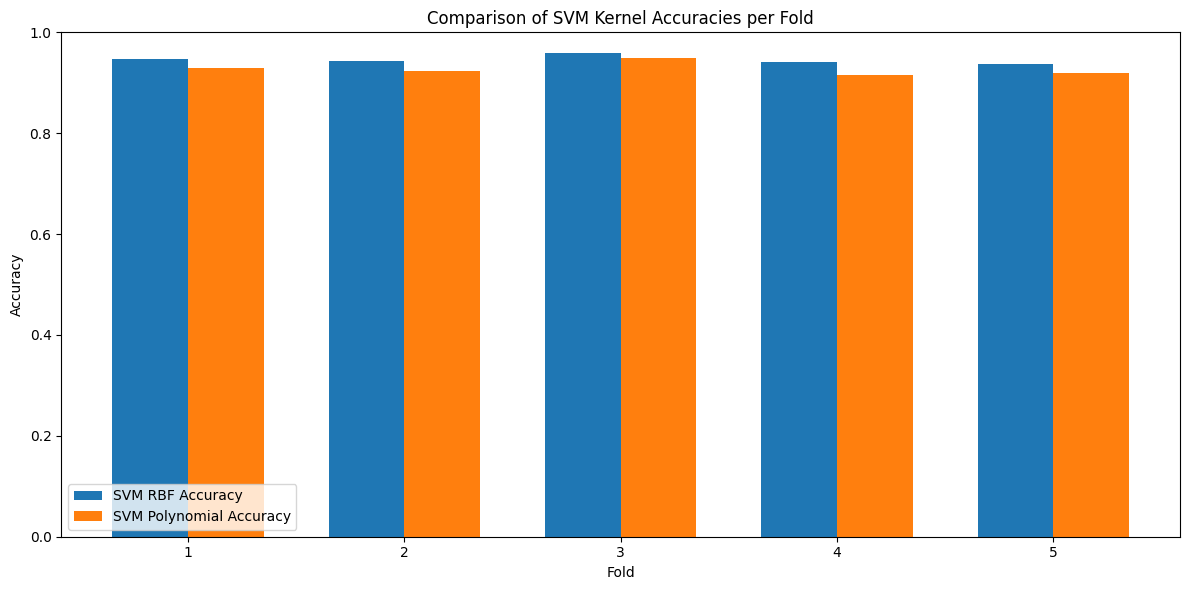

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Number of folds
n_folds = len(accuracies_rbf)

# Prepare x-axis for the number of folds
folds = np.arange(1, n_folds + 1)

# Width of the bars
bar_width = 0.35

# Plotting
plt.figure(figsize=(12, 6))

# Bar graph for RBF and Polynomial kernel accuracies
plt.bar(folds - bar_width/2, accuracies_rbf, bar_width, label='SVM RBF Accuracy')
plt.bar(folds + bar_width/2, accuracies_poly, bar_width, label='SVM Polynomial Accuracy')

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Comparison of SVM Kernel Accuracies per Fold')
plt.xticks(folds)
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()